In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 


In [3]:
with open("datasets/tinyShakespeare.txt", "r") as f:
    load = f.read()
print(load[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [4]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load[2000:]]
valset = [texttoint[c] for c in load[:2000]]

sequence_length = 3
vocab_size = len(texttoint)
inputs = torch.tensor(dataset[:-1])
labels = torch.tensor(dataset[1:])
val_inputs = torch.tensor(valset[:-1])
val_labels = torch.tensor(valset[1:])

In [15]:
emb_size = 10
hidden_size = 128

class Model(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, 5)
        self.node = Node(5, 5)
        self.fc1 = nn.Linear(5, vocab_size)

    def forward(self, inputs):
        emb = self.embeddings(inputs)
        x = self.node(emb)
        return  self.fc1(x)

model = Model(vocab_size, emb_size, hidden_size)

In [16]:
epochs = 2000
batch_size = 1024
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

lossi = []
vlossi = []

from tqdm import tqdm
for epoch in (p:=tqdm(range(epochs))):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes]) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred, labels[indexes])

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        p.set_description(f"Loss: {loss.item()}")

    with torch.no_grad():
        pred = model(val_inputs)
        vloss = F.cross_entropy(pred, val_labels)
        vlossi.append(vloss.item())

        # 2.50

Loss: 2.6139423847198486: 100%|██████████| 2000/2000 [13:21<00:00,  2.49it/s]


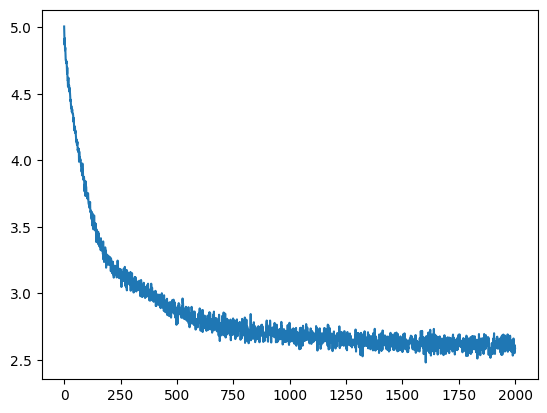

In [20]:
plt.plot(lossi)

In [7]:
a = torch.arange(0, 1, 0.1)
b = torch.bernoulli(a)
b

tensor([0., 0., 1., 1., 0., 1., 1., 0., 1., 1.])

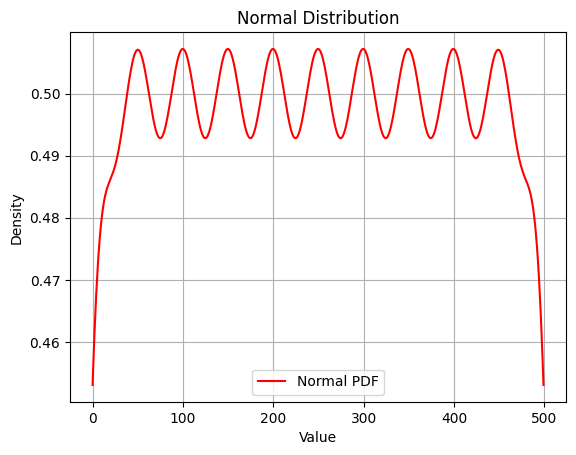

In [33]:
import torch
import matplotlib.pyplot as plt

# Create a normal distribution with mean 0 and standard deviation 1
pdf = torch.zeros(500)
for i in range(-10, 11, 2):
    pdf += torch.exp(torch.distributions.normal.Normal(i, 1).log_prob(torch.linspace(-10, 10, 500)))
plt.plot(pdf.numpy(), 'r-', label='Normal PDF')

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Normal Distribution')
plt.legend()
plt.grid(True)
plt.show()


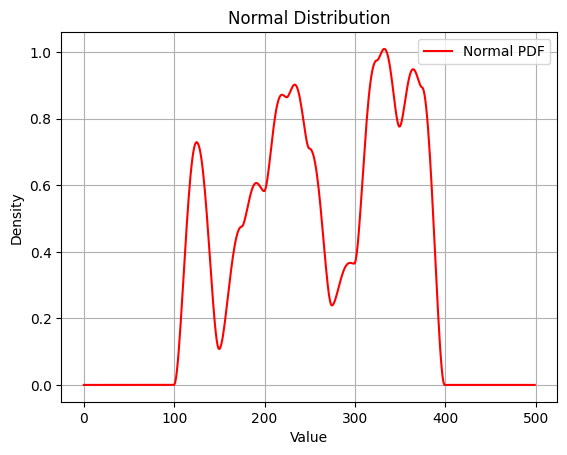

In [28]:
# Fast spline 

def distrib(x, shift=0): 
    value = x - shift
    value[value < -1] = -1
    value[value > 1] = 1
    return (value**4 - 2*value**2 + 1)

pdf = torch.zeros(500)
weights = torch.rand(11)
for n, i in enumerate(range(-5, 6, 1)):
    # if i == 5 or i == 4 or i == 2 or i == 8: continue
    pdf += distrib(torch.linspace(-10, 10, 500), i) * weights[n]
plt.plot(pdf.numpy(), 'r-', label='Normal PDF')

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Normal Distribution')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
class Spline(nn.Module):
    def __init__(self):
        super(Spline, self).__init__()
        self.range = torch.arange(-5, 6, 0.25)
        n_distr = len(self.range)
        self.weights = nn.Parameter(torch.randn(n_distr) / 3).requires_grad_(True)

    def forward(self, x):
        distributions = torch.stack([distrib(x, shift) for shift in self.range], -1)
        x = distributions @ self.weights
        return x

class Node(nn.Module):
    def __init__(self, input_size=2, out_size=5):
        super(Node, self).__init__()
        self.embed = nn.ModuleList([Spline() for _ in range(out_size * input_size)])
        self.out_size = out_size

    def forward(self, x):
        embed_outputs = []
        for n, emb in enumerate(self.embed):
            embed_outputs.append(emb(x[..., n // self.out_size]))
        x = torch.stack(embed_outputs, -1)
        return x.view(*x.shape[:-1], self.out_size, -1).sum(-1)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.node1 = Node(1, 2)
        self.node2 = Node(2, 1)

    def forward(self, x):
        x = self.node1(x)
        x = self.node2(x)
        return x


In [916]:
       
x = torch.arange(-5, 6, 0.02)
y = torch.e**torch.sin(x)

model = Spline()
lossi = []
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)




In [917]:

from tqdm import tqdm
for epoch in (p:=tqdm(range(800))):
    indices = torch.randint(0, len(x), (16,))
    
    # print(x[indices].numpy().round(2))
    pred = model(x[indices])

    # print(pred.shape)
    loss = F.mse_loss(pred, y[indices])
    lossi.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    p.set_description(f"Loss: {loss.item():.4f}")


Loss: 0.0006: 100%|██████████| 800/800 [00:10<00:00, 73.00it/s]


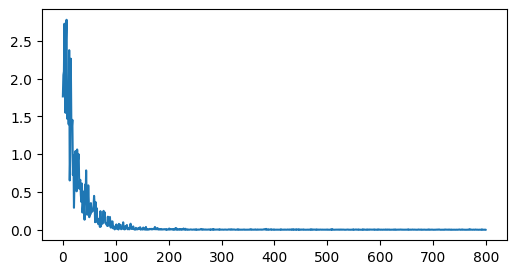

In [918]:
plt.figure(figsize=(6, 3))  
plt.plot(torch.tensor(lossi).view(-1, 1).mean(1))

In [919]:
# pdf = (torch.stack([distrib(torch.arange(-5, 6, 0.1), shift) for shift in range(-5, 6, 1)], -1)*model.weights.detach().numpy())
# plt.plot(pdf)

torch.Size([110])


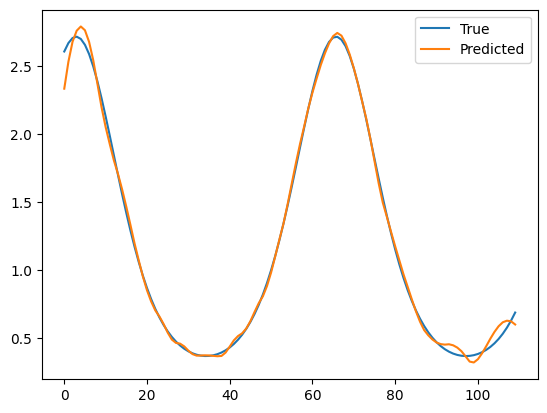

In [920]:
x = torch.arange(-5, 6, 0.1)  
y = torch.e**torch.sin(x)
pred = model(x.view(-1))

print(pred.shape)
plt.plot(y, label='True')
plt.plot(pred.detach().numpy()[:], label='Predicted')
plt.legend()
plt.show()

In [923]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) # this is a list of linear layers
        self.fc2 = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        for hidden in self.fcx:    # iterating over hidden layers
            x = F.gelu(hidden(x))  # applying each hidden layer
        return self.fc2(x)


model = Model(emb_size=10, hidden_size=32, n_layers=2)

epochs = 3000
batch_size = 16
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # 3e-4 is a good learning rate for Adam on big models

lossi = []
vlossi = []

from tqdm import tqdm
for epoch in (p:=tqdm(range(epochs))):
    indices = torch.randint(0, len(x), (16,))
    
    # print(x[indices].numpy().round(2))
    pred = model(x[indices].view(-1, 1))

    # print(pred.shape)
    loss = F.mse_loss(pred[:, 0], y[indices])
    lossi.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    p.set_description(f"Loss: {loss.item():.4f}")


Loss: 0.0027: 100%|██████████| 3000/3000 [00:15<00:00, 189.32it/s]


torch.Size([110, 1])


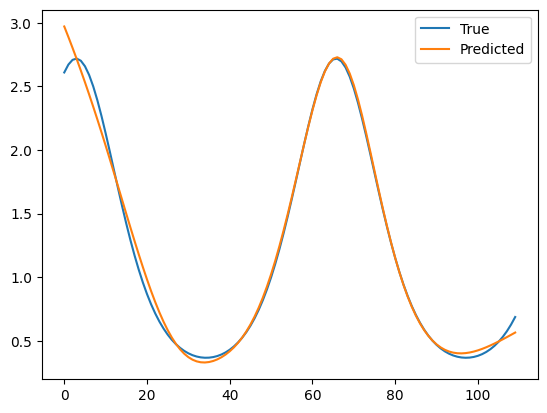

In [925]:
x = torch.arange(-5, 6, 0.1)  
y = torch.e**torch.sin(x)
pred = model(x.view(-1, 1))

print(pred.shape)
plt.plot(y, label='True')
plt.plot(pred.detach().numpy()[:], label='Predicted')
plt.legend()
plt.show()